<a href="https://colab.research.google.com/github/RayyanAlFirdausi/Machine_Learning/blob/main/UTS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Load required library
# Import Required Library
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from skimage.feature import hog
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import seaborn as sns
import cv2 as cv
import dlib

# Load Data

In [2]:
# Load Dataset
# We will load dataset only for faces with contain min 10 images
# We also want to keep images in color; color=True
faces = fetch_lfw_people(min_faces_per_person=10, color=True)

# Check Faces
print(f'Total Label: {len(faces.target_names)}')
print(f'Data dimension: {faces.images.shape}')
print(f'Images flatten dimension: {faces.data.shape}')

Total Label: 158
Data dimension: (4324, 62, 47, 3)
Images flatten dimension: (4324, 8742)


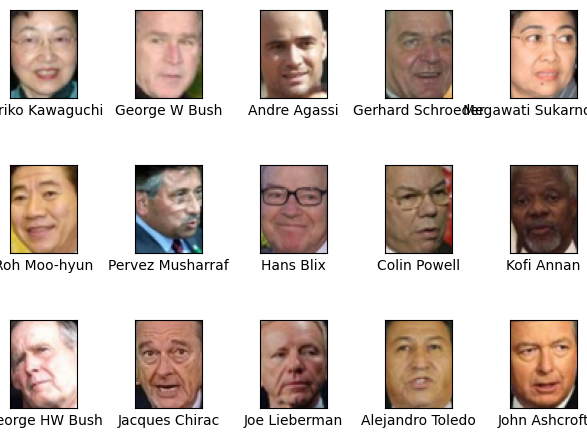

In [3]:
# Check by Plotted Images
# Generate random 15 images
rand_labels = [np.random.randint(0, len(faces.data)) for x in range(0,15)]

fig, ax = plt.subplots(3, 5)
fig.tight_layout()
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[rand_labels[i]], cmap='bone')
    axi.set(xticks=[], yticks=[],
            xlabel=faces.target_names[faces.target[rand_labels[i]]])

# Preparations

In [4]:
def convert_to_grayscale(image):
    if len(image.shape) == 2:
        return image

    return cv.cvtColor(image, cv.COLOR_BGR2GRAY)

faces.images = [convert_to_grayscale(image) for image in faces.images]

# Feature Extraction

In [5]:
def extract_feature_hist_hog():
  features = []

  for image in faces.images:
    histogram =  hog(image, orientations=7, pixels_per_cell=(8, 8),cells_per_block=(4, 4),block_norm= 'L2-Hys' ,transform_sqrt = False)
    features.append(histogram)

  return features

# Metode Clustering DBSCAN

Jumlah kluster unik yang ditemukan: 1
Jumlah noise (label -1): 0


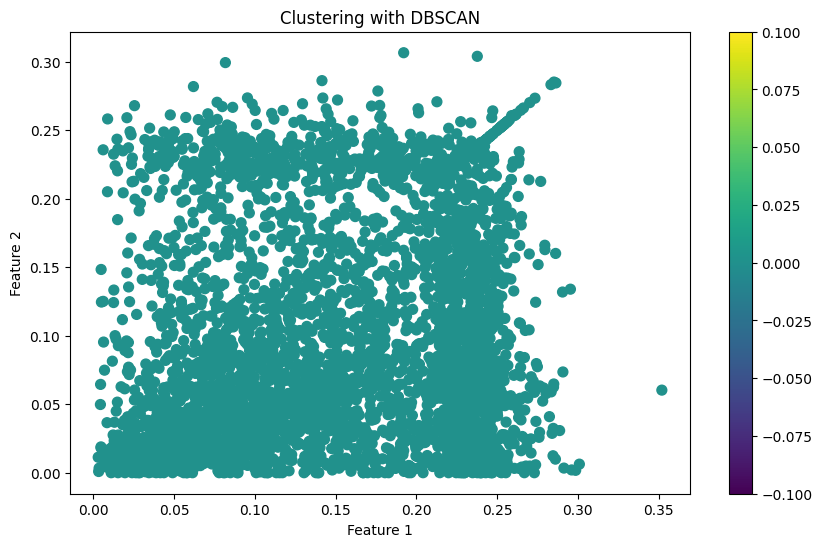

In [6]:
# Ekstraksi fitur HOG dari dataset
X_hog = extract_feature_hist_hog()

# Konversi ke NumPy array jika X_hog adalah list
X_hog = np.array(X_hog)

# Model SVM menggunakan histogram dari Numpy
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_hog, faces.target, test_size=0.2, random_state=42, stratify=faces.target)

# Penerapan DBSCAN untuk clustering
dbscan = DBSCAN(eps=25, min_samples=20, metric='euclidean')

# Fit model ke data fitur HOG
dbscan.fit(X_hog)

# Mendapatkan label dari clustering
labels = dbscan.labels_

# Menampilkan hasil
print(f'Jumlah kluster unik yang ditemukan: {len(set(labels)) - (1 if -1 in labels else 0)}')
print(f'Jumlah noise (label -1): {list(labels).count(-1)}')

# Visualisasi Hasil Clustering Tanpa PCA (menggunakan dua fitur pertama dari data HOG)
# Pastikan ada cukup fitur
if X_hog.shape[1] >= 2:
    plt.figure(figsize=(10, 6))
    plt.scatter(X_hog[:, 0], X_hog[:, 1], c=labels, cmap='viridis', s=50)
    plt.title('Clustering with DBSCAN')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.colorbar()
    plt.show()
else:
    print("Tidak cukup fitur untuk visualisasi.")

# Silhouette Score

In [7]:
from sklearn.metrics import silhouette_score

# Pastikan labels bukan hanya noise
if len(set(labels)) > 1 and -1 not in labels:
    score = silhouette_score(X_hog, labels)
    print(f'Silhouette Score: {score}')
else:
    print("Tidak cukup kluster valid untuk menghitung silhouette score.")

Tidak cukup kluster valid untuk menghitung silhouette score.


In [8]:
from keras.models import Sequential
from keras.layers import Dense, Dropout

# Membangun model ANN
model = Sequential()
model.add(Dense(128, input_shape=(X_hog.shape[1],), activation='relu'))  # Lapisan input
model.add(Dropout(0.5))  # Dropout untuk mengurangi overfitting
model.add(Dense(64, activation='relu'))  # Lapisan tersembunyi
model.add(Dropout(0.5))  # Dropout untuk mengurangi overfitting
model.add(Dense(len(faces.target_names), activation='softmax'))  # Lapisan output

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Melatih model
history = model.fit(X_train1, y_train1,
                    epochs=30,
                    batch_size=32,
                    validation_split=0.2)

# Evaluasi model
loss, accuracy = model.evaluate(X_test1, y_test1)
print(f'Test Accuracy: {accuracy:.4f}')

# Prediksi dan hasil klasifikasi
y_pred = np.argmax(model.predict(X_test1), axis=-1)

# Menampilkan confusion matrix dan classification report
conf_matrix = confusion_matrix(y_test1, y_pred)
class_report = classification_report(y_test1, y_pred, target_names=faces.target_names)

print('Confusion Matrix:\n', conf_matrix)
print('\nClassification Report:\n', cl ass_report)

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.0646 - loss: 4.9091 - val_accuracy: 0.1113 - val_loss: 4.6580
Epoch 2/30
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1270 - loss: 4.6072 - val_accuracy: 0.1113 - val_loss: 4.5741
Epoch 3/30
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.1282 - loss: 4.5303 - val_accuracy: 0.1329 - val_loss: 4.4606
Epoch 4/30
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.1294 - loss: 4.4346 - val_accuracy: 0.1474 - val_loss: 4.3962
Epoch 5/30
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.1335 - loss: 4.4016 - val_accuracy: 0.1561 - val_loss: 4.3274
Epoch 6/30
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.1574 - loss: 4.2784 - val_accuracy: 0.1575 - val_loss: 4.2588
Epoch 7/30
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.1683 - loss: 4.1933 - val_accuracy: 0.1590 - val_loss: 4.2160
Epoch 8/30
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1863 - loss: 4.0929 - val_accuracy: 0.1691 - val_loss: 4.1535
Epo

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
